### Quantum circuit for XY model.

We want create a quantum circuit $U_{dis}$ such that $$H_{XY} =U_{dis}\tilde{H}U_{dis}^\dagger $$.

Using this circuit, we can 
* start from a eigenstate(product state) of the non-interaction Hamiltonian $\tilde{H}$ to create the excited eigenstates of $H_{XY}$
* simulate time evolution of a state
* simulate thermal state $exp(-\beta H_{XY})$

In [22]:
import tequila as tq
import numpy as np
from numpy import pi
import qiskit

In [23]:
from qiskit import IBMQ
MY_IBMQ_TOKEN=
IBMQ.save_account(MY_IBMQ_TOKEN, overwrite=True) # needs to be done once, and is then saved in our environment
IBMQ.load_account()
# see the list of backends that you can use:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
print(provider.backends())

ibmqfactory.load_account:WARNING:2021-01-03 22:36:44,077: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_valencia') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>, <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>]


[Alba's code](https://github.com/qiskit-community/qiskit-community-tutorials/blob/6de54e7033edc4233142caecda257ed72a6735f5/awards/teach_me_qiskit_2018/exact_ising_model_simulation/Ising_time_evolution.ipynb)

[Solve the 1D Ising model ](https://stanford.edu/~jeffjar/statmech/lec4.html)  

Magnetization density $m = M/N = <\sigma_z^j>$ is the same for any spin $j$.

In [3]:
def fSWAP(q0,q1):
    circuit = tq.gates.CNOT(q0,q1) + tq.gates.CNOT(q1,q0) + tq.gates.CNOT(q0,q1)
    circuit += tq.gates.CZ(q0,q1)
    return circuit
    
    
qiskit_fswap = tq.compile(fSWAP(0,1),backend = 'qiskit')

In [4]:
qiskit_fswap.circuit.draw()

┌───┐        
q_0: ──■──┤ X ├──■───■─
     ┌─┴─┐└─┬─┘┌─┴─┐ │ 
q_1: ┤ X ├──■──┤ X ├─■─
     └───┘     └───┘   
c: 2/══════════════════

Why do we have to decompose gates to CX? Is it necessary for the simulation?

In [5]:
tq.show_available_simulators()

backend         | wfn        | sampling   | noise      | installed 
--------------------------------------------------------------------
qulacs_gpu      | False      | False      | False      | False     
qulacs          | True       | True       | True       | True      
qibo            | False      | False      | False      | False     
qiskit          | True       | True       | True       | True      
cirq            | True       | True       | True       | True      
pyquil          | False      | False      | False      | False     
symbolic        | True       | False      | False      | True      


In [6]:
# CH (Controlled-Haddamard)
# control qubit: q1
# target qubit: q0
def CH2(q0,q1):
    circuit = tq.gates.Phase(phi=-pi/2,target=q0) + tq.gates.H(q0) + tq.gates.Phase(phi=-pi/4,target=q0)
    circuit += tq.gates.H(q0) + tq.gates.H(q1) + tq.gates.CNOT(q0,q1) + tq.gates.H(q0) +tq.gates.H(q1)
    circuit += tq.gates.T(q0) + tq.gates.H(q0) + tq.gates.S(q0)
    return circuit
qiskit_mix = tq.compile(CH2(0,1),backend = 'qiskit')
# Fourier transform gates

def F2(q0,q1):
    circuit = tq.gates.CNOT(q0,q1) + CH2(q0,q1) + tq.gates.CNOT(q0,q1) +tq.gates.CZ(q0,q1)
    return circuit

def F0(q0,q1):
    return F2(q0,q1)
    
def F1(q0,q1):
    return F2(q0,q1) + tq.gates.Phase(phi=-pi/2,target=q0)

                                            
    

In [7]:
qiskit_mix.circuit.draw()

┌──────────┐┌───┐┌──────────┐┌───┐     ┌───┐┌─────────┐┌───┐┌─────────┐
q_0: ┤ RZ(-π/2) ├┤ H ├┤ RZ(-π/4) ├┤ H ├──■──┤ H ├┤ RZ(π/4) ├┤ H ├┤ RZ(π/2) ├
     └──┬───┬───┘└───┘└──────────┘└───┘┌─┴─┐├───┤└─────────┘└───┘└─────────┘
q_1: ───┤ H ├──────────────────────────┤ X ├┤ H ├───────────────────────────
        └───┘                          └───┘└───┘                           
c: 2/═══════════════════════════════════════════════════════════════════════

In [8]:
from math import pi

# control qubit: q0
# target qubit: q1
def CRX(theta, q0, q1):
    circuit = tq.gates.Rz(angle=pi/2.0,target=q1) + tq.gates.Ry(angle=theta, target=q1) + tq.gates.CNOT(q0,q1)
    circuit += tq.gates.Ry(angle=-pi/2.0,target=q1) + tq.gates.CNOT(q0,q1) + tq.gates.Rz(angle=-pi/2.0,target=q1)
    return circuit

def B(theta_k,q0,q1):
#     circuit = tq.gates.X(q1) + tq.gates.CX(control=q1,target=q0) +CRX(theta_k,q0,q1) + tq.gates.CX(control=q1,target=q0)+tq.gates.X(q1)
    circuit = tq.gates.X(q1) + tq.gates.CX(control=q1,target=q0) +tq.gates.CRx(control=q0,target=q1,angle=theta_k) + tq.gates.CX(control=q1,target=q0)+tq.gates.X(q1)

    return circuit

In [9]:
def Udisg(lam,q0,q1,q2,q3):
    k=1
    n=4
    th1=-np.arccos((lam-np.cos(2*pi*k/n))/np.sqrt((lam-np.cos(2*pi*k/n))**2+np.sin(2*pi*k/n)**2))
    circuit = B(th1,q0,q1)+ F1(q0,q1) + F0(q2,q3)
    #fSWAP(Udis,q2,q1) # for ibmqx2
    #fSWAP(Udis,q1,q2) # for ibmqx4
    circuit += F0(q0,q2)
    circuit += F0(q1,q3)
    #fSWAP(Udis,q2,q1) # for ibmqx2
    #fSWAP(Udis,q1,q2) # for ibmqx4
    return circuit

def Ising(lam,q0,q1,q2,q3):
    if lam<1:
        return tq.gates.X(q3) + Udisg(lam,q0,q1,q2,q3)
    else:
        return Udisg(lam,q0,q1,q2,q3)
    


In [10]:
qiskit_ising = tq.compile(Ising(2,0,1,2,3),backend = 'qiskit')
qiskit_ising.circuit.draw()

┌───┐                                                             »
q_0: ────────┤ X ├───────────────────────────■───────────────────■─────────────»
     ┌───┐   └─┬─┘    ┌───┐┌──────────────┐┌─┴─┐┌─────────────┐┌─┴─┐   ┌───┐   »
q_1: ┤ X ├─────■──────┤ H ├┤ RZ(-0.23182) ├┤ X ├┤ RZ(0.23182) ├┤ X ├───┤ H ├───»
     └───┘┌──────────┐├───┤└─┬──────────┬─┘├───┤└─────────────┘├───┤┌──┴───┴──┐»
q_2: ──■──┤ RZ(-π/2) ├┤ H ├──┤ RZ(-π/4) ├──┤ H ├───────■───────┤ H ├┤ RZ(π/4) ├»
     ┌─┴─┐└──┬───┬───┘└───┘  └──────────┘  └───┘     ┌─┴─┐     ├───┤└─────────┘»
q_3: ┤ X ├───┤ H ├───────────────────────────────────┤ X ├─────┤ H ├───────────»
     └───┘   └───┘                                   └───┘     └───┘           »
c: 4/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«     ┌───┐                ┌──────────┐┌───┐┌──────────┐┌───┐     ┌───┐»
«q_0: ┤ X ├─────────────■──┤ RZ(-π/2) ├┤ H ├┤ RZ(-π/4) ├┤ H ├──■──┤ H ├»
«     └─┬─┘   ┌───┐   ┌─┴─┐└──┬───┬───┘└───┘└──────────┘└───┘┌─┴─┐├───┤»
«q_1: ──■─────┤ X ├───┤ X ├───┤ H ├──────────────────────────┤ X ├┤ H ├»
«     ┌───┐┌──┴───┴──┐└───┘   └───┘                          └───┘└───┘»
«q_2: ┤ H ├┤ RZ(π/2) ├──■───────■──────────────────────────────────────»
«     └───┘└─────────┘┌─┴─┐     │                                      »
«q_3: ────────────────┤ X ├─────■──────────────────────────────────────»
«                     └───┘                                            »
«c: 4/═════════════════════════════════════════════════════════════════»
«                                                                      »
«     ┌─────────┐┌───┐┌─────────┐        ┌──────────┐     ┌──────────┐┌───┐»
«q_0: ┤ RZ(π/4) ├┤ H ├┤ RZ(π/2) ├──■───■─┤ RZ(-π/2) ├──■──┤ RZ(-π/2) ├┤ H ├»
«     └─────────┘└───┘└─────────┘┌─┴─┐ │ └──────────┘  │  ├──────────┤├───┤»
«q_1: ───────────────────────────┤ X ├─■──────■────────┼──┤ RZ(-π/2) ├┤ H ├»
«                                └───┘        │      ┌─┴─┐└──┬───┬───┘└───┘»
«q_2: ────────────────────────────────────────┼──────┤ X ├───┤ H ├─────────»
«                                           ┌─┴─┐    ├───┤   └───┘         »
«q_3: ──────────────────────────────────────┤ X ├────┤ H ├─────────────────»
«                                           └───┘    └───┘                 »
«c: 4/═════════════════════════════════════════════════════════════════════»
«                                                                          »
«     ┌──────────┐┌───┐          ┌───┐┌─────────┐┌───┐┌─────────┐             »
«q_0: ┤ RZ(-π/4) ├┤ H ├───────■──┤ H ├┤ RZ(π/4) ├┤ H ├┤ RZ(π/2) ├───────■─────»
«     ├──────────┤├───┤       │  ├───┤├─────────┤├───┤├─────────┤       │     »
«q_1: ┤ RZ(-π/4) ├┤ H ├──■────┼──┤ H ├┤ RZ(π/4) ├┤ H ├┤ RZ(π/2) ├──■────┼───■─»
«     └──────────┘└───┘  │  ┌─┴─┐├───┤└─────────┘└───┘└─────────┘  │  ┌─┴─┐ │ »
«q_2: ───────────────────┼──┤ X ├┤ H ├─────────────────────────────┼──┤ X ├─┼─»
«                      ┌─┴─┐├───┤└───┘                           ┌─┴─┐└───┘ │ »
«q_3: ─────────────────┤ X ├┤ H ├────────────────────────────────┤ X ├──────■─»
«                      └───┘└───┘                                └───┘        »
«c: 4/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«        
«q_0: ─■─
«      │ 
«q_1: ─┼─
«      │ 
«q_2: ─■─
«        
«q_3: ───
«        
«c: 4/═══
«

Use digitsum to calculate expectation

In [11]:
def digit_sum(n):
    num_str = str(n)
    sum = 0
    for i in range(0, len(num_str)):
        sum += int(num_str[i])
    return sum

In [12]:
shots = 1024
mag_sim = []
for i in range(10):
    lam = 0.2*i
    wfn = tq.simulate(Ising(lam,0,1,2,3),backend='qiskit',samples=shots)
    r1 = []
    r2 = []
    for key, value in wfn.items():
        r1 +=[key.binary]
        r2 +=[value]
    M = 0
    for j in range(len(r1)):
        M = M + (4-2*digit_sum(r1[j]))*r2[j]/shots
    mag_sim.append(M/4)

In [13]:
#Real Device
real_device = 'ibmq_santiago'
mag = []
for i in range(10):
    lam = 0.2*i
    wfn = tq.simulate(Ising(lam,0,1,2,3),backend='qiskit',device = real_device,samples=shots)
    r1 = []
    r2 = []
    for key, value in wfn.items():
        r1 +=[key.binary]
        r2 +=[value]
    M = 0
    for j in range(len(r1)):
        M = M + (4-2*digit_sum(r1[j]))*r2[j]/shots
    mag.append(M/4)

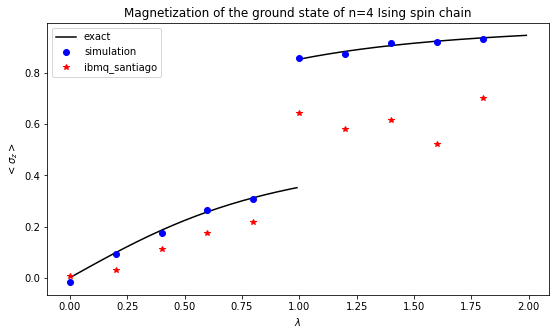

In [14]:

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy import linalg as la
def exact(lam):
    if lam <1:
        return lam/(2*np.sqrt(1+lam**2))
    if lam >1:
        return 1/2+lam/(2*np.sqrt(1+lam**2))
    return None
vexact = np.vectorize(exact)
l=np.arange(0.0,2.0,0.01)
l1=np.arange(0.0,2.0,0.2)
plt.figure(figsize=(9,5))
plt.plot(l,vexact(l),'k',label='exact')
plt.plot(l1, mag_sim, 'bo',label='simulation')
plt.plot(l1, mag, 'r*',label='ibmq_santiago')
plt.xlabel('$\lambda$')
plt.ylabel('$<\sigma_{z}>$')
plt.legend()
plt.title('Magnetization of the ground state of n=4 Ising spin chain')
plt.show()


# Use tq.ExpectationValue to calculate magnetization.

In [15]:
circuit = Ising(0.2,0,1,2,3)
qiskit_ising = tq.compile(Ising(0.2,0,1,2,3),backend = 'qiskit')
# qiskit_ising.circuit.draw()

In [16]:
shots = 1024
mag_sim = []
H = tq.paulis.Z([1])
for i in range(10):
    lam = 0.2*i
    circuit = Ising(lam,0,1,2,3)

    M_exp = tq.ExpectationValue(H = H, U = circuit)
    M=tq.simulate(M_exp,backend='qiskit',samples=shots)
    mag_sim.append(M)

In [24]:
# Real Device
real_device = 'ibmq_santiago'
shots = 1024
mag = []
H = tq.paulis.Z([1])
for i in range(10):
    lam = 0.2*i
    circuit = Ising(lam,0,1,2,3)

    M_exp = tq.ExpectationValue(H = H, U = circuit)
    M=tq.simulate(M_exp,backend='qiskit',device = real_device,samples=shots)
    mag.append(M)

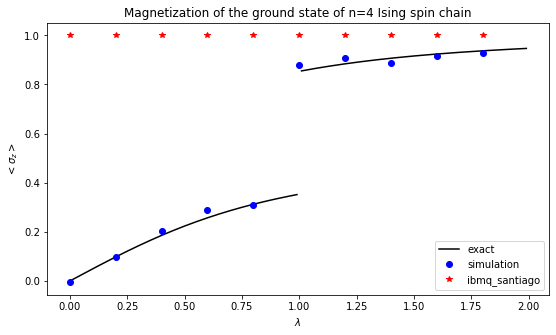

In [25]:
def exact(lam):
    if lam <1:
        return lam/(2*np.sqrt(1+lam**2))
    if lam >1:
        return 1/2+lam/(2*np.sqrt(1+lam**2))
    return None
vexact = np.vectorize(exact)
l=np.arange(0.0,2.0,0.01)
l1=np.arange(0.0,2.0,0.2)
plt.figure(figsize=(9,5))
plt.plot(l,vexact(l),'k',label='exact')
plt.plot(l1, mag_sim, 'bo',label='simulation')
plt.plot(l1, mag, 'r*',label='ibmq_santiago')
plt.xlabel('$\lambda$')
plt.ylabel('$<\sigma_{z}>$')
plt.legend()
plt.title('Magnetization of the ground state of n=4 Ising spin chain')
plt.show()


### Time Evolution of $|\uparrow>^{\otimes4}=|0>^{\otimes 4}$ (in $H_{XY}$ basis)

First find the corresponding state in the diagonal basis ($\tilde{H}$)

$$|\tilde{\psi}_0>=U_{dis}^{\dagger}|0000>=\cos{\phi}|0000>+i\sin{\phi}|1100>$$
$$\phi = \frac{1}{2}\arccos{\frac{-\lambda+\cos{\frac{2\pi k}{n}} }{\sqrt{(\lambda-\cos{\frac{2\pi k}{n} })^2 +\gamma^2\sin^2{\frac{2\pi k}{n}}}}}$$

For Ising model $\gamma =1,k=1,n=4$,$$\phi = \frac{1}{2}\arccos(\frac{\lambda}{\sqrt{1+\lambda^2}})$$

The time evolution of $|\tilde{\psi}(t)> = e^{-itE_i}$

$$|\tilde{\psi}(t)> =(\cos\phi|00>+ie^{4it\sqrt{1+\lambda^2}}\sin\phi|11>)\otimes|00>$$

We impelement this state using $R_y(2\phi)=e^{-i\phi\sigma_y} = \cos\phi-i\sigma_y\sin\phi=\begin{pmatrix}
\cos\phi & -\sin\phi \\
\sin\phi & \cos\phi 
\end{pmatrix}$ and also a phase gate for the phase $-ie^{4it\sqrt{1+\lambda^2}}$

In [18]:
import numpy as np
def Initial_time(t,lam,q0,q1,q2,q3):
    circuit = tq.gates.Ry(np.arccos(lam/np.sqrt(1+lam**2)),q0)+tq.gates.Phase(3*pi/2+4*t*np.sqrt(1+lam**2),q0)
    circuit += tq.gates.CNOT(q0,q1)
    return circuit

def Ising_time(t,lam,q0,q1,q2,q3):
#     if lam<1:
#         return tq.gates.X(q3) + Initial_time(t,lam,q0,q1,q2,q3) + Udisg(lam,q0,q1,q2,q3)
#     else:
    return Initial_time(t,lam,q0,q1,q2,q3) + Udisg(lam,q0,q1,q2,q3)

In [19]:
shots = 1024
nlam=3
magt_sim=[[] for _ in range(nlam)]
lam0=[0.5,0.9,1.8]
for j in range(nlam):
    lam=lam0[j]
    for i in range(9):
        t=i*0.25
        wfn = tq.simulate(Ising_time(t,lam,0,1,2,3),backend='qiskit',samples=shots)
        r1 = []
        r2 = []
        for key, value in wfn.items():
            r1 +=[key.binary]
            r2 +=[value]
        #print(r1)
        M=0
        for k in range(0,len(r1)):
            M=M+(4-2*digit_sum(r1[k]))*r2[k]/shots
        magt_sim[j].append(M/4)

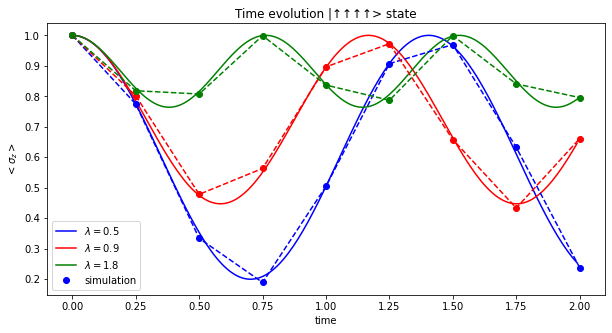

In [20]:

def exact_time(lam,tt):
    Mt=(1 + 2*lam**2 + np.cos(4*tt*np.sqrt(1 + lam**2)))/(2 + 2*lam**2)
    return Mt
vexact_t = np.vectorize(exact_time)
t=np.arange(0.0,2.0,0.01)
tt=np.arange(0.0,2.25,0.25)
plt.figure(figsize=(10,5))
plt.plot(t,vexact_t(0.5,t),'b',label='$\lambda=0.5$')
plt.plot(t,vexact_t(0.9,t),'r',label='$\lambda=0.9$')
plt.plot(t,vexact_t(1.8,t),'g',label='$\lambda=1.8$')
plt.plot(tt, magt_sim[0], 'bo',label='simulation')
plt.plot(tt, magt_sim[1], 'ro')
plt.plot(tt, magt_sim[2], 'go')
# plt.plot(tt, magt_sim[0], 'b*',label='ibmqx5')
# plt.plot(tt, magt_sim[1], 'r*')
# plt.plot(tt, magt_sim[2], 'g*')
plt.plot(tt, magt_sim[0], 'b--')
plt.plot(tt, magt_sim[1], 'r--')
plt.plot(tt, magt_sim[2], 'g--')
plt.xlabel('time')
plt.ylabel('$<\sigma_{z}>$')
plt.legend()
plt.title('Time evolution |↑↑↑↑> state')
plt.show()

test